#Markov Sampling for Pascal dataset

In [1]:
# Import all the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale



---


Connecting  to the  Google drive


---



In [2]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---


Reading the csv file made for the dataset - currently working only for 6 classes.


---



In [6]:
# Read the dataset
data = pd.read_csv("/content/drive/MyDrive/Image-pixels.csv")
data.shape

(4382, 22501)



---


Append the label column in the dataset read 


---



In [7]:
col=[i for i in range(22500)]
col.append('label')
data.columns=col
data.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
         22491,   22492,   22493,   22494,   22495,   22496,   22497,   22498,
         22499, 'label'],
      dtype='object', length=22501)

In [9]:
x = data.drop("label", axis = 1)
y = data['label']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.7, random_state = 101)
model_linear = SVC(kernel='linear')
model_linear.fit(train_x, train_y)

pred_y = model_linear.predict(test_x)

In [10]:
print("test_y are: ")
print(test_y)
print("pred_y from the SVC model are :")
print(pred_y)

test_y are: 
940     1.0
3192    4.0
4228    6.0
4253    6.0
121     0.0
       ... 
4027    6.0
1441    2.0
3996    6.0
832     1.0
3761    5.0
Name: label, Length: 3068, dtype: float64
pred_y from the SVC model are :
[4. 4. 2. ... 6. 2. 5.]


In [11]:
# Helper Functions
def exist(dic,limit):
    for i,val in dic.items():
        if val<limit:
            return True
    return False        

def lossF(actual,pred):
    if actual==pred:
        return 1.0
    return np.exp(-2)    

## Starting with the algorithm : 


---


### MARKOV SAMPLING FOR SVMC


---


**Step 1** : Let m be the size of training
samples and m%2 be the remainder
of m divided by 2. m+ and m−
denote the size of training samples
which label are +1 and −1,
respectively. Draw randomly N1
(N1 ≤
m) training samples {zi} N1
 i=1 from
the dataset Dtr. Then we can obtain a
preliminary learning model f0
 by
SVMC and these samples.Set m+ = 0
and m− = 0.


---




---


**Step 2 :** Draw randomly a sample
from Dtr and denote it the current
sample zt. If m%2 = 0, set m+ = m+ + 1 if the label of zt is +1, or set m−
= m− + 1 if the label of zt is −1.


---


In [14]:
# initialise parameters for markov
markov = pd.DataFrame(columns = data.columns)
uniqCls=list(np.sort(data['label'].unique()))
classCNT=len(uniqCls)
limit=250
m=classCNT*limit
mcls={i:0 for i in uniqCls}

k=5
q=1.2
acc=0
i=np.random.randint(data.shape[0])
z0=data.iloc[i]
y0=model_linear.predict(np.array([z0.drop('label')]))[0]
if m%classCNT==0:
    mcls[z0['label']]+=1



---


# Step 3 To Step 6


---

**Step 3 :**  Draw randomly another sample from Dtr and denote it the candidate sample z∗.

**Step 4 :** Calculate the ratio P of e−(f0,z) at the sample z∗
 and the sample zt, P = e−(f0 ,z∗)/e−(f0 ,zt).

**Step 5 :** If P = 1, yt = −1 and y∗ = −1 accept z∗ with probability P = e−y∗f0 /e−ytf0. If P =1, yt = 1 and y∗ = 1 accept z∗ with probability P= e−y∗f0 /e−yt*f0. If P = 1 and yty∗ = −1 or P < 1, accept z∗  with probability P. If there are k candidate samples z∗ can not be accepted continuously, then set P = qP and with probability P accept z∗. Set z+1 = z∗, m+ = m+ +1 if the label of zt is +1, or set m− = m− + 1 if the label of zt is −1 [if the accepted probability P (or P, P) is larger than 1, accept z∗ with probability 1].

**Step 6 :** If m+ < m/2 or m− < m/2 then return to Step 3, else stop it.


---




In [15]:
pred_prob=[]
lst=[]

while exist(mcls,limit):
    i=np.random.randint(data.shape[0])
    while i in lst:
        i=np.random.randint(data.shape[0])
    lst.append(i)
    z1=data.iloc[i]
    y1=model_linear.predict(np.array([z1.drop('label')]))[0]
    n=lossF(z1['label'],y1)
    d=lossF(z0['label'],y0)
    p=n/d

    if acc==k:
        acc=0
        p2=q*p
        p2=min(p2,1)
        pred_prob.append([z1['label'],y1,p2])
        markov=markov.append(z1)
        z0=z1
        mcls[z1['label']]+=1
        acc+=1
    elif p==1 and z0['label']==z1['label']:
        n=np.exp(-y1*z1['label'])
        d=np.exp(-y0*z0['label'])

        p1=n/d
        p1=min(p1,1)
        pred_prob.append([z1['label'],y1,p1])
        markov=markov.append(z1)
        z0=z1
        mcls[z1['label']]+=1
        acc+=1
    elif p<1:
        pred_prob.append([z1['label'],y1,p])
        markov=markov.append(z1)
        z0=z1
        mcls[z1['label']]+=1
        acc+=1
    elif p==1 and z0['label']!=z1['label']:
        pred_prob.append([z1['label'],y1,p])
        markov=markov.append(z1)
        z0=z1
        mcls[z1['label']]+=1
        acc+=1
print("The generated Markov Chain :")
print(markov)
print("The predicted Probabilities :")
print(pred_prob)

The generated Markov Chain :
          0      1      2      3      4  ...  22496  22497  22498  22499  label
4200   28.0   29.0   30.0   33.0   29.0  ...   30.0   30.0   29.0   32.0    6.0
46    169.0  169.0  173.0  172.0  172.0  ...  167.0  170.0  170.0  168.0    0.0
2726  148.0  153.0  150.0  158.0  149.0  ...   42.0   47.0   44.0   50.0    4.0
3204  243.0  243.0  244.0  245.0  245.0  ...   31.0   37.0   34.0   34.0    4.0
3122  235.0  235.0  238.0  238.0  238.0  ...  124.0  128.0  129.0  127.0    4.0
...     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
212   116.0  115.0  115.0  115.0  116.0  ...  130.0  130.0  130.0  130.0    0.0
903   136.0  159.0  151.0  176.0  138.0  ...   84.0   83.0   92.0  103.0    1.0
1865  255.0  255.0  255.0  255.0  255.0  ...  163.0  169.0  175.0  140.0    3.0
2601  102.0  109.0  105.0  103.0   97.0  ...  240.0   73.0   96.0   87.0    4.0
2048   18.0   17.0   18.0   42.0   40.0  ...  125.0  138.0  132.0  130.0    3.0

[2399 rows



---


Save data from generated markov chain

---



In [16]:
markov.to_csv("/content/drive/MyDrive/markovSamplesPascal1.csv")



---


Creating a new list for predicted probability and appending new column or field to save the probability in the markov chain generated 

---





In [17]:
prob=[]
for i in pred_prob:
    prob.append(i[2])
markov['probability']=prob



---


Save the Predicted Probability


---



In [18]:
markov.to_csv("/content/drive/MyDrive/markovSamplesPascalProbability1.csv")

In [19]:
data.to_csv('/content/drive/MyDrive/remainingPascal1.csv')

# SVM

In [20]:
train = pd.read_csv("/content/drive/MyDrive/markovSamplesPascal1.csv")
test = pd.read_csv("/content/drive/MyDrive/remainingPascal1.csv")

In [21]:
train = train.drop(train.columns[[0]], axis=1)
test = test.drop(test.columns[[0]], axis=1)
train_x = train.drop("label", axis = 1)
train_y = train["label"]

test_x = test.drop("label", axis = 1)
test_y = test["label"]

In [22]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import chi2_kernel
 
def hellinger(X1, X2):
  return np.sqrt(np.dot(X1,X2.T))

def intersection(X1,X2):
  result = np.zeros((X1.shape[0],X2.shape[0]))
  X2=X2.T
  for i in range(len(X1)):
    for j in range(len(X2[0])):
      val=float('+inf')
      for k in range(len(X2)):
        val = min(val,X1[i][k] * X2[k][j])

      result[i][j]=val

  return result

Accuracy for all the kernels - linear, rbf, chi-squared, hellinger, intersection



In [23]:
x_axis = ['linear', 'rbf', 'chi-squared', 'hellinger']
y_axis = []
model_linear = SVC(kernel='linear')
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
acc = metrics.accuracy_score(y_true=test_y, y_pred=pred_y)
y_axis.append(acc)
print("Accuracy for linear kernel:", acc, "\n")

model_linear = SVC(kernel='rbf')
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
acc = metrics.accuracy_score(y_true=test_y, y_pred=pred_y)
y_axis.append(acc)
print("Accuracy for rbf kernel:", acc, "\n")

model_linear = SVC(kernel=chi2_kernel)
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
acc = metrics.accuracy_score(y_true=test_y, y_pred=pred_y)
y_axis.append(acc)
print("Accuracy for Chi-Squared kernel:", acc, "\n")

model_linear = SVC(kernel=hellinger)
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
acc = metrics.accuracy_score(y_true=test_y, y_pred=pred_y)
y_axis.append(acc)
print("Accuracy for Hellinger kernel:", acc, "\n")


Accuracy for linear kernel: 0.6097672295755363 

Accuracy for rbf kernel: 0.4835691465084436 

Accuracy for Chi-Squared kernel: 0.6074851665905979 

Accuracy for Hellinger kernel: 0.3539479689639434 



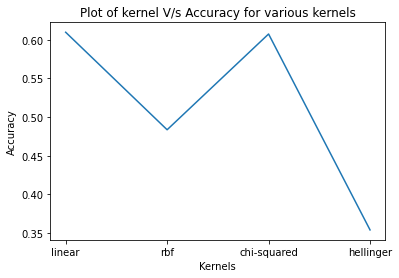

In [27]:
plt.plot(x_axis, y_axis)
plt.xlabel("Kernels")
plt.ylabel("Accuracy")
plt.title("Plot of kernel V/s Accuracy for various kernels")
plt.show()

In [ ]:
# Due to time and resources constraint, were unable to run for this kernel
model_linear = SVC(kernel=intersection)
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
print("accuracy for Intersection kernel:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")
